In [1]:
# Environment setup
const DEPENDENCIES = ["PrettyTables", "BenchmarkTools", "TiledIteration", "CairoMakie", "GraphViz"];
import Pkg
Pkg.activate(temp=true)
Pkg.add(name="DataFlowTasks", rev="7f0138ab2e1c5b9e75697fe966745bf4e6053daf")
foreach(Pkg.add, DEPENDENCIES)

  Activating new project at `/tmp/jl_eCJAqH`
   Resolving package versions...
    Updating `/tmp/jl_eCJAqH/Project.toml`
  [d1549cb6] + DataFlowTasks v0.2.0 `https://github.com/maltezfaria/DataFlowTasks.jl.git#7f0138a`
    Updating `/tmp/jl_eCJAqH/Manifest.toml`
  [34da2185] + Compat v4.14.0
  [d1549cb6] + DataFlowTasks v0.2.0 `https://github.com/maltezfaria/DataFlowTasks.jl.git#7f0138a`
  [bac558e1] + OrderedCollections v1.6.3
  [6c6a2e73] + Scratch v1.2.1
  [0dad84c5] + ArgTools v1.1.1
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [f43a241f] + Downloads v1.6.0
  [7b1f6079] + FileWatching
  [b77e0a4c] + InteractiveUtils
  [b27032c2] + LibCURL v0.6.4
  [76f85450] + LibGit2
  [8f399da3] + Libdl
  [37e2e46d] + LinearAlgebra
  [56ddb016] + Logging
  [d6f4376e] + Markdown
  [ca575930] + NetworkOptions v1.2.0
  [44cfe95a] + Pkg v1.10.0
  [de0858da] + Printf
  [3fa0cd96] + REPL
  [9a3f8284] + Random
  [ea8e919c] + SHA v0.7.0
  [9e88b42a] + Serialization
  [6462fe0b] +

# Longest Common Subsequence


The problem of finding the [Longest Common
Subsequence](https://en.wikipedia.org/wiki/Longest_common_subsequence) between
two sequences finds numerous applications in fields as diverse as computer
sciences or bioinformatics. In this example, we'll implement a parallel
dynamic programming approach to solving such problems.

The idea behind this approach is that, if we denote by $LCS(X,Y)$ the longest
common subsequence of two sequences $X$ and $Y$, then $LCS$ satisfies the two
following properties:

$$
\begin{align}
& LCS(X*c, Y*c) = LCS(X, Y) * c \\
& LCS(X*c_1, Y*c_2) \in \left\{ LCS(X*c_1, Y), LCS(X, Y*c_2)\right\} & \text{if } c_1 \neq c_2
\end{align}
$$

where $X*c$ denotes the concatenation of sequence $X$ with character $c$. The
first property above allows simplifying the Longest Common Subsequence
computation of two sequences that end with the same character. When the two
sequences end with different characters, the second property allows
simplifying the problem to a choice between two possibilities.

If we now denote by $L_{i,j}$ the length of the longest common subsequence
between the first $i$ characters of $X$ and the first $j$ characters of $Y$,
then we now have the following property for $L$:

$$
L_{i,j} = \left\{
\begin{array}{ll}
0 & \text{ if } i=0 \text{ or } j=0\\
1 + L_{i-1, j-1} & \text{ if } i\neq 0 \text{ and } j\neq 0 \text{ and } x_i = y_j\\
\text{max}\left(L_{i-1, j}, L_{i,j-1}\right) & \text{ if } i\neq 0 \text{ and } j\neq 0 \text{ and } x_i \neq y_j\\
\end{array}
\right.
$$

where $x_i$ represents the $i$-th character in sequence $X$ and $y_j$ the $j$-th character in sequence $Y$.

If $L$ is stored in an array, the first condition above allows initializing
its first row and first column. Then, the neighboring cells can be filled
using the two other conditions, which in turn unlocks further neighboring
cells until the whole $L$ matrix is filled.

## Small example

Let us begin with a small example: we want to find a longest common subsequence between `GAC` and `AGCAT`:

In [2]:
x = collect("GAC");
y = collect("AGCAT");

Let's build the $L$ array. For the sake of the example, we'll initially fill
it with $(-1)$ in order to indicate which values haven't been computed yet.
The `init_buffer(x,y)` function simply initiaizes a buffer matrix `L` of the
appropriate size, while `init_length!(L)` takes a matrix and fills its first
row and first column with zeros. We also define a `display` helper function,
which shows a pretty representation of the $L$ array.

In [3]:
init_buffer(x, y) = Matrix{Int}(undef, 1 + length(x), 1 + length(y))

function init_lengths!(L)
    L[:, 1] .= 0
    return L[1, :] .= 0
end

using PrettyTables
function display(L, x, y)
    return pretty_table(
        hcat(['∅', x...], L);
        header = [' ', '∅', y...],
        formatters = (v, i, j) -> v == -1 ? "" : v,
    )
end

L = fill!(init_buffer(x, y), -1)
init_lengths!(L)
display(L, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │   │   │   │   │   │
│ A │ 0 │   │   │   │   │   │
│ C │ 0 │   │   │   │   │   │
└───┴───┴───┴───┴───┴───┴───┘


The `fill_lengths!` function then allows filling other rows. By default it
will fill the entire array, but for the sake of the example we restrict it
here to a subset of the rows and/or the columns.

In [4]:
function fill_lengths!(L, x, y, ir = eachindex(x), jr = eachindex(y))
    @inbounds for j in jr, i in ir
        L[i+1, j+1] = (x[i] == y[j]) ? L[i, j] + 1 : max(L[i+1, j], L[i, j+1])
    end
end

fill_lengths!(L, x, y, 1:1)
display(L, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │ 0 │ 1 │ 1 │ 1 │ 1 │
│ A │ 0 │   │   │   │   │   │
│ C │ 0 │   │   │   │   │   │
└───┴───┴───┴───┴───┴───┴───┘


After the first row has been filled, we see that $L_{1,1} = 0$ because we
can't extract any common subsequence from the first characters in $X$ (`G`)
and $Y$ (`A`). However, $L_{1,2}=1$ because the first character of $X$ (`G`)
matches the second character of $Y$ (which is also `G`). In turn this causes
all other $L_{1,j}$ values to be equal to 1.

Now that the first row is complete, we can fill the remaining two rows in the
array:

In [5]:
fill_lengths!(L, x, y, 2:3)
display(L, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │ 0 │ 1 │ 1 │ 1 │ 1 │
│ A │ 0 │ 1 │ 1 │ 1 │ 2 │ 2 │
│ C │ 0 │ 1 │ 1 │ 2 │ 2 │ 2 │
└───┴───┴───┴───┴───┴───┴───┘


We now know that the longest common subsequence between $X$ and $Y$ has a
length of 2. In order to actually find a subsequence of this length, we can
"backtrack" from the bottom right of the array back to the top left:

In [6]:
function backtrack(L, x, y)
    i = lastindex(x)
    j = lastindex(y)
    subseq = Char[]
    while L[i+1, j+1] != 0
        if x[i] == y[j]
            pushfirst!(subseq, x[i])
            (i, j) = (i - 1, j - 1)
        elseif L[i+1, j] > L[i, j+1]
            (i, j) = (i, j - 1)
        else
            (i, j) = (i - 1, j)
        end
    end
    return String(subseq)
end

backtrack(L, x, y)

"GA"

Wrapping everything into a function, we get

In [7]:
function LCS!(L, x, y)
    init_lengths!(L)
    fill_lengths!(L, x, y)
    return backtrack(L, x, y)
end
LCS(x, y) = LCS!(init_buffer(x, y), x, y)

LCS(x, y)

"GA"

Note that we define both an in-place version of the algorithm, which takes a
pre-allocated array as input, and another version which allocates the array
internally.

## Large example

Let's test this on larger data. The results obtained with this sequential
version of the algorithm will serve as reference to check the validity of more
complex implementations.

In [8]:
import Random;
Random.seed!(42);
x = rand("ATCG", 4096);
y = rand("ATCG", 8192);
seq = LCS(x, y)
length(seq)

3575

We can also measure the elapsed time for this implementation, which will serve
as a base line to assess the performance of other implementations described
below.

In [9]:
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1
t_seq = @belapsed LCS!(L, $x, $y) setup = (L = init_buffer(x, y))

0.250937903

### Tiled sequential version

We'll now build a tiled version of the same algorithm. The
[`TiledIteration.jl`](https://github.com/JuliaArrays/TiledIteration.jl)
package implements various tools allowing to define and iterate over disjoint
tiles of a larger array. Among these, the `SplitAxis` function allows
splitting a range of indices into a given number of chunks:

In [10]:
using TiledIteration
SplitAxis(1:20, 3)  # split the range 1:20 into 3 chunks of approximately equal sizes

3-element TiledIteration.SplitAxis:
 1:6
 7:13
 14:20

A tiled version of the previous algorithm is then as simple as filling the
chunks one after the other:

In [11]:
function LCS_tiled!(L, x, y, nx, ny)
    init_lengths!(L)
    for jrange in SplitAxis(eachindex(y), ny)
        for irange in SplitAxis(eachindex(x), nx)
            fill_lengths!(L, x, y, irange, jrange)
        end
    end
    return backtrack(L, x, y)
end
LCS_tiled(x, y, nx, ny) = LCS_tiled!(init_buffer(x, y), x, y, nx, ny)

LCS_tiled (generic function with 1 method)

Here we split the problem into $10 \times 10$ blocks, and check that the tiled
version gives the same results as the plain implementation above. Even without
parallelization, and depending on the characteristics of the system, tiling
may already be beneficial in terms of performance because it is more
cache-friendly:

In [12]:
nx = ny = 10
tiled = LCS_tiled(x, y, nx, ny)
@assert seq == tiled

t_tiled = @belapsed LCS_tiled!(L, $x, $y, nx, ny) setup = (L = init_buffer(x, y))

0.213451169

!!! note "Tiling and cache effects"
    The tiled version of the algorithm above is not exactly equivalent to the
    sequential version, because the array is visited in a different way when
    the tiles are used. This can have an impact on the performance, depending
    on the characteristics of the system and the problem size. In particular,
    the tiled version may be more cache-friendly, which can lead to better
    performance even in the absence of parallelization.

## Tiled parallel version

Parallelizing the tiled version using `DataFlowTasks` is now relatively
straightforward: it only requires annotating the code to expose data
dependencies.

In our case:

- the initialization task writes to the first row and first column of the
  array. In this parallel implementation, initialization will be done
  tile-by-tile as well using `fill!` on a `view` of `L`;

- filling a tile involves reading `L` for the provided ranges of indices, and
  writing to a range of indices shifted by 1;

- backtracking reads the whole `L` array.

Note that the backtracking task needs to be fetched in order to get the result
in a synchronous way and perform an apple-to-apple comparison to the previous
implementations.

In [13]:
using DataFlowTasks

init_lengths!(L, ir, jr) = fill!(view(L, ir, jr), 0)

function LCS_par!(L, x, y, nx, ny)
    L[1,1] = 0
    for (ky, jrange) in enumerate(SplitAxis(eachindex(y), ny))
        L1j = view(L, 1, jrange .+ 1)
        @dspawn fill!(@W(L1j), 0) label = "init (1, $(ky+1))"
        for (kx, irange) in enumerate(SplitAxis(eachindex(x), nx))
            Lx1 = view(L, irange .+ 1, 1)
            ky == 1 && @dspawn fill!(@W(Lx1), 0) label = "init ($(kx+1), 1)"
            @dspawn begin
                @R view(L, irange, jrange)
                @W view(L, irange .+ 1, jrange .+ 1)
                fill_lengths!(L, x, y, irange, jrange)
            end label = "tile ($kx, $ky)"
        end
    end

    bt = @dspawn backtrack(@R(L), x, y) label = "backtrack"
    return fetch(bt)
end
LCS_par(x, y, nx, ny) = LCS_par!(init_buffer(x, y), x, y, nx, ny)

LCS_par (generic function with 1 method)

Again, we can check that this implementation produces the correct results, and
measure its run-time.

In [14]:
par = LCS_par(x, y, nx, ny)
@assert seq == par
t_par = @belapsed LCS_par!(L, $x, $y, nx, ny) setup = (L = init_buffer(x, y))

0.066228869

As an added safety measure, let's also check that the task dependency graph
looks as expected:

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.10/Project.toml`
⌃ [13f3f980] CairoMakie v0.10.12
⌃ [e9467ef8] GLMakie v0.8.12
  [f526b714] GraphViz v0.2.0
⌅ [ee78f7c6] Makie v0.19.12
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


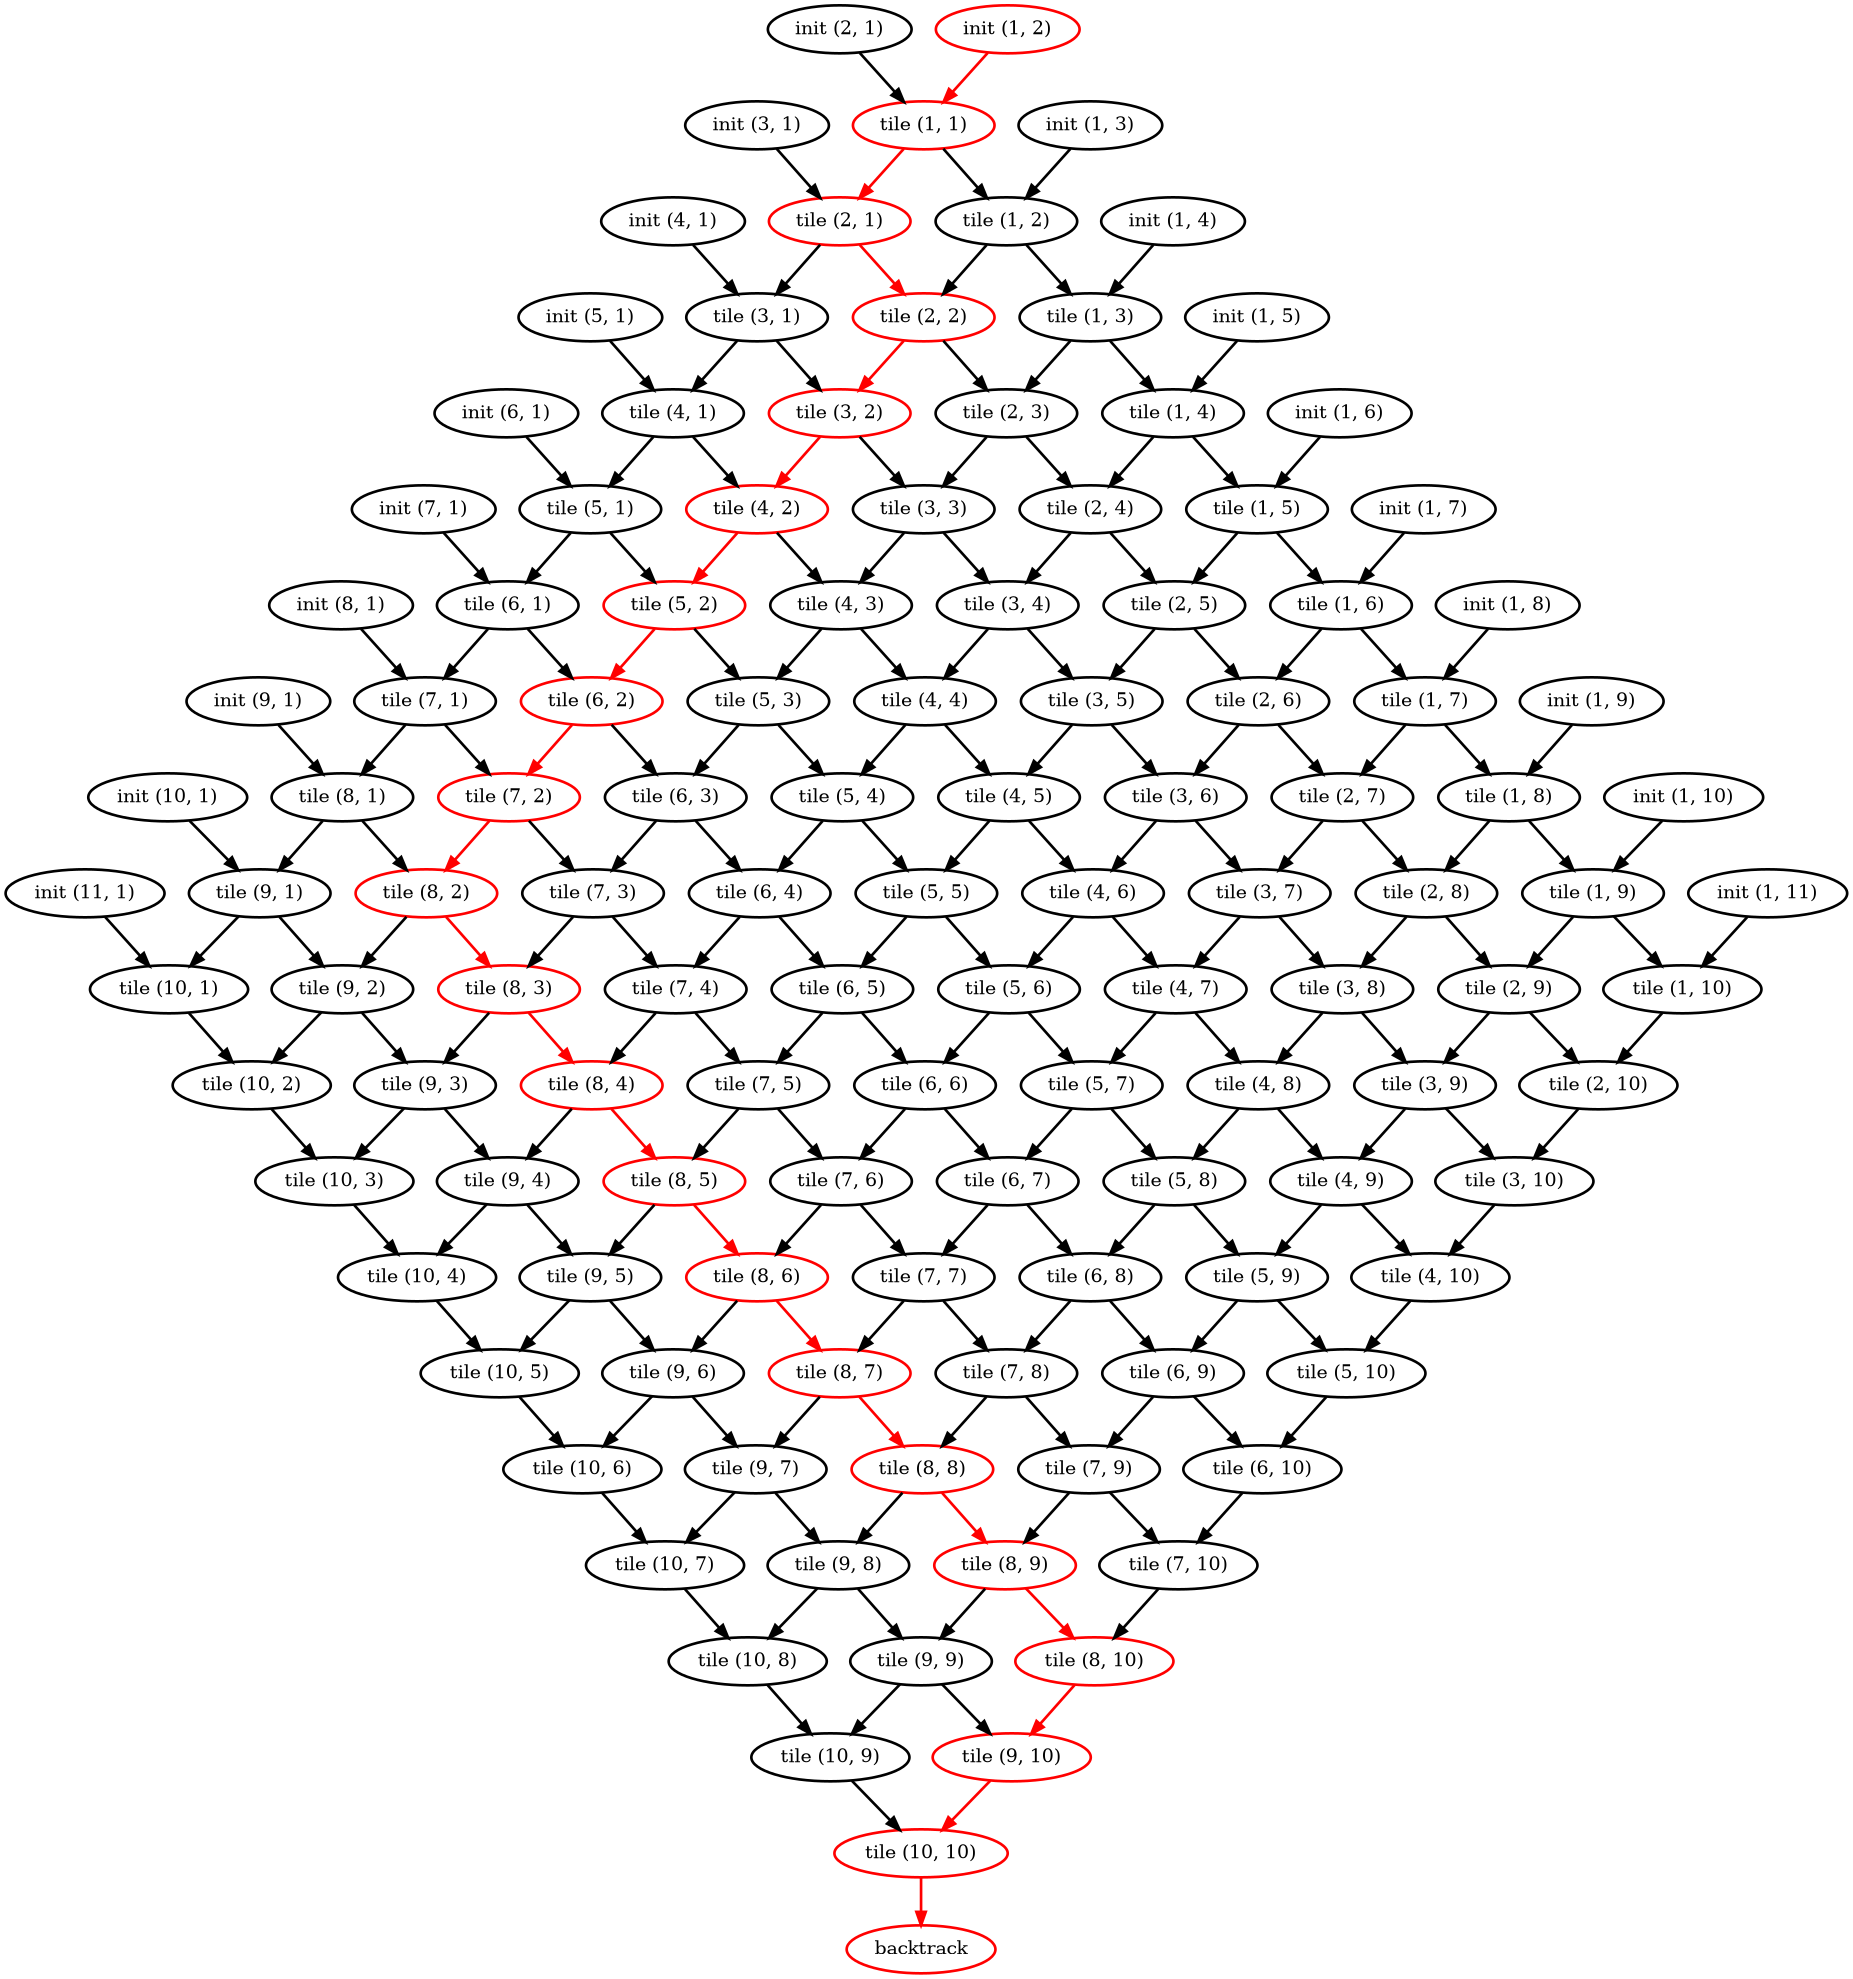

In [15]:
import DataFlowTasks as DFT
resize!(DFT.get_active_taskgraph(), 300)
GC.gc()
log_info = DFT.@log LCS_par(x, y, nx, ny)

DFT.stack_weakdeps_env!()
using GraphViz
dag = GraphViz.Graph(log_info)

## Performance comparison

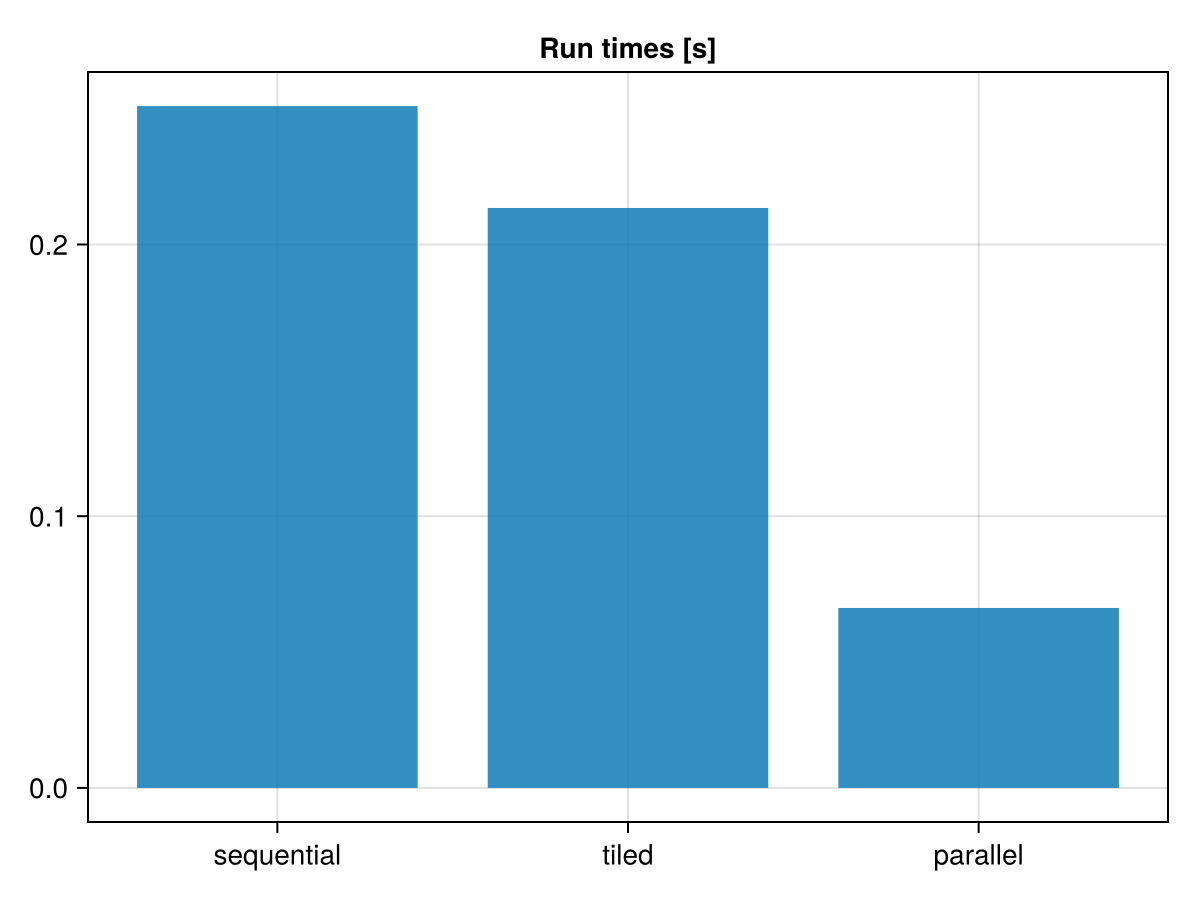

In [16]:
using CairoMakie
barplot(
    1:3,
    [t_seq, t_tiled, t_par];
    axis = (; title = "Run times [s]", xticks = (1:3, ["sequential", "tiled", "parallel"])),
)

Comparing the performances of these 3 implementations, the tiled version may,
depending on the system, already saves some time due to cache effects. The the
parallel version does show some speedup, but not as much as one might expect:

In [17]:
(; nthreads = Threads.nthreads(), speedup  = t_seq / t_par)

(nthreads = 8, speedup = 3.788950449991831)

Let's try and understand why. The run-time data collected above contains useful information

In [18]:
DFT.describe(log_info; categories = ["init", "tile", "backtrack"])

• Elapsed time           : 0.092
  ├─ Critical Path       : 0.091
  ╰─ No-Wait             : 0.053

• Run time               : 0.733
  ├─ Computing           :   0.424
  │  ├─ init             :     0.078
  │  ├─ tile             :     0.346
  │  ├─ backtrack        :     0.000
  │  ╰─ unlabeled        :     0.000
  ├─ Task Insertion      :   0.001
  ╰─ Other (idle)        :   0.307


which we can also visualize in a profiling plot. This gives some insight about
the performances of our parallel version:

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220
[ Info: Computing    : 0.424425157
[ Info: Inserting    : 0.00111251
[ Info: Other        : 0.30696315062671514


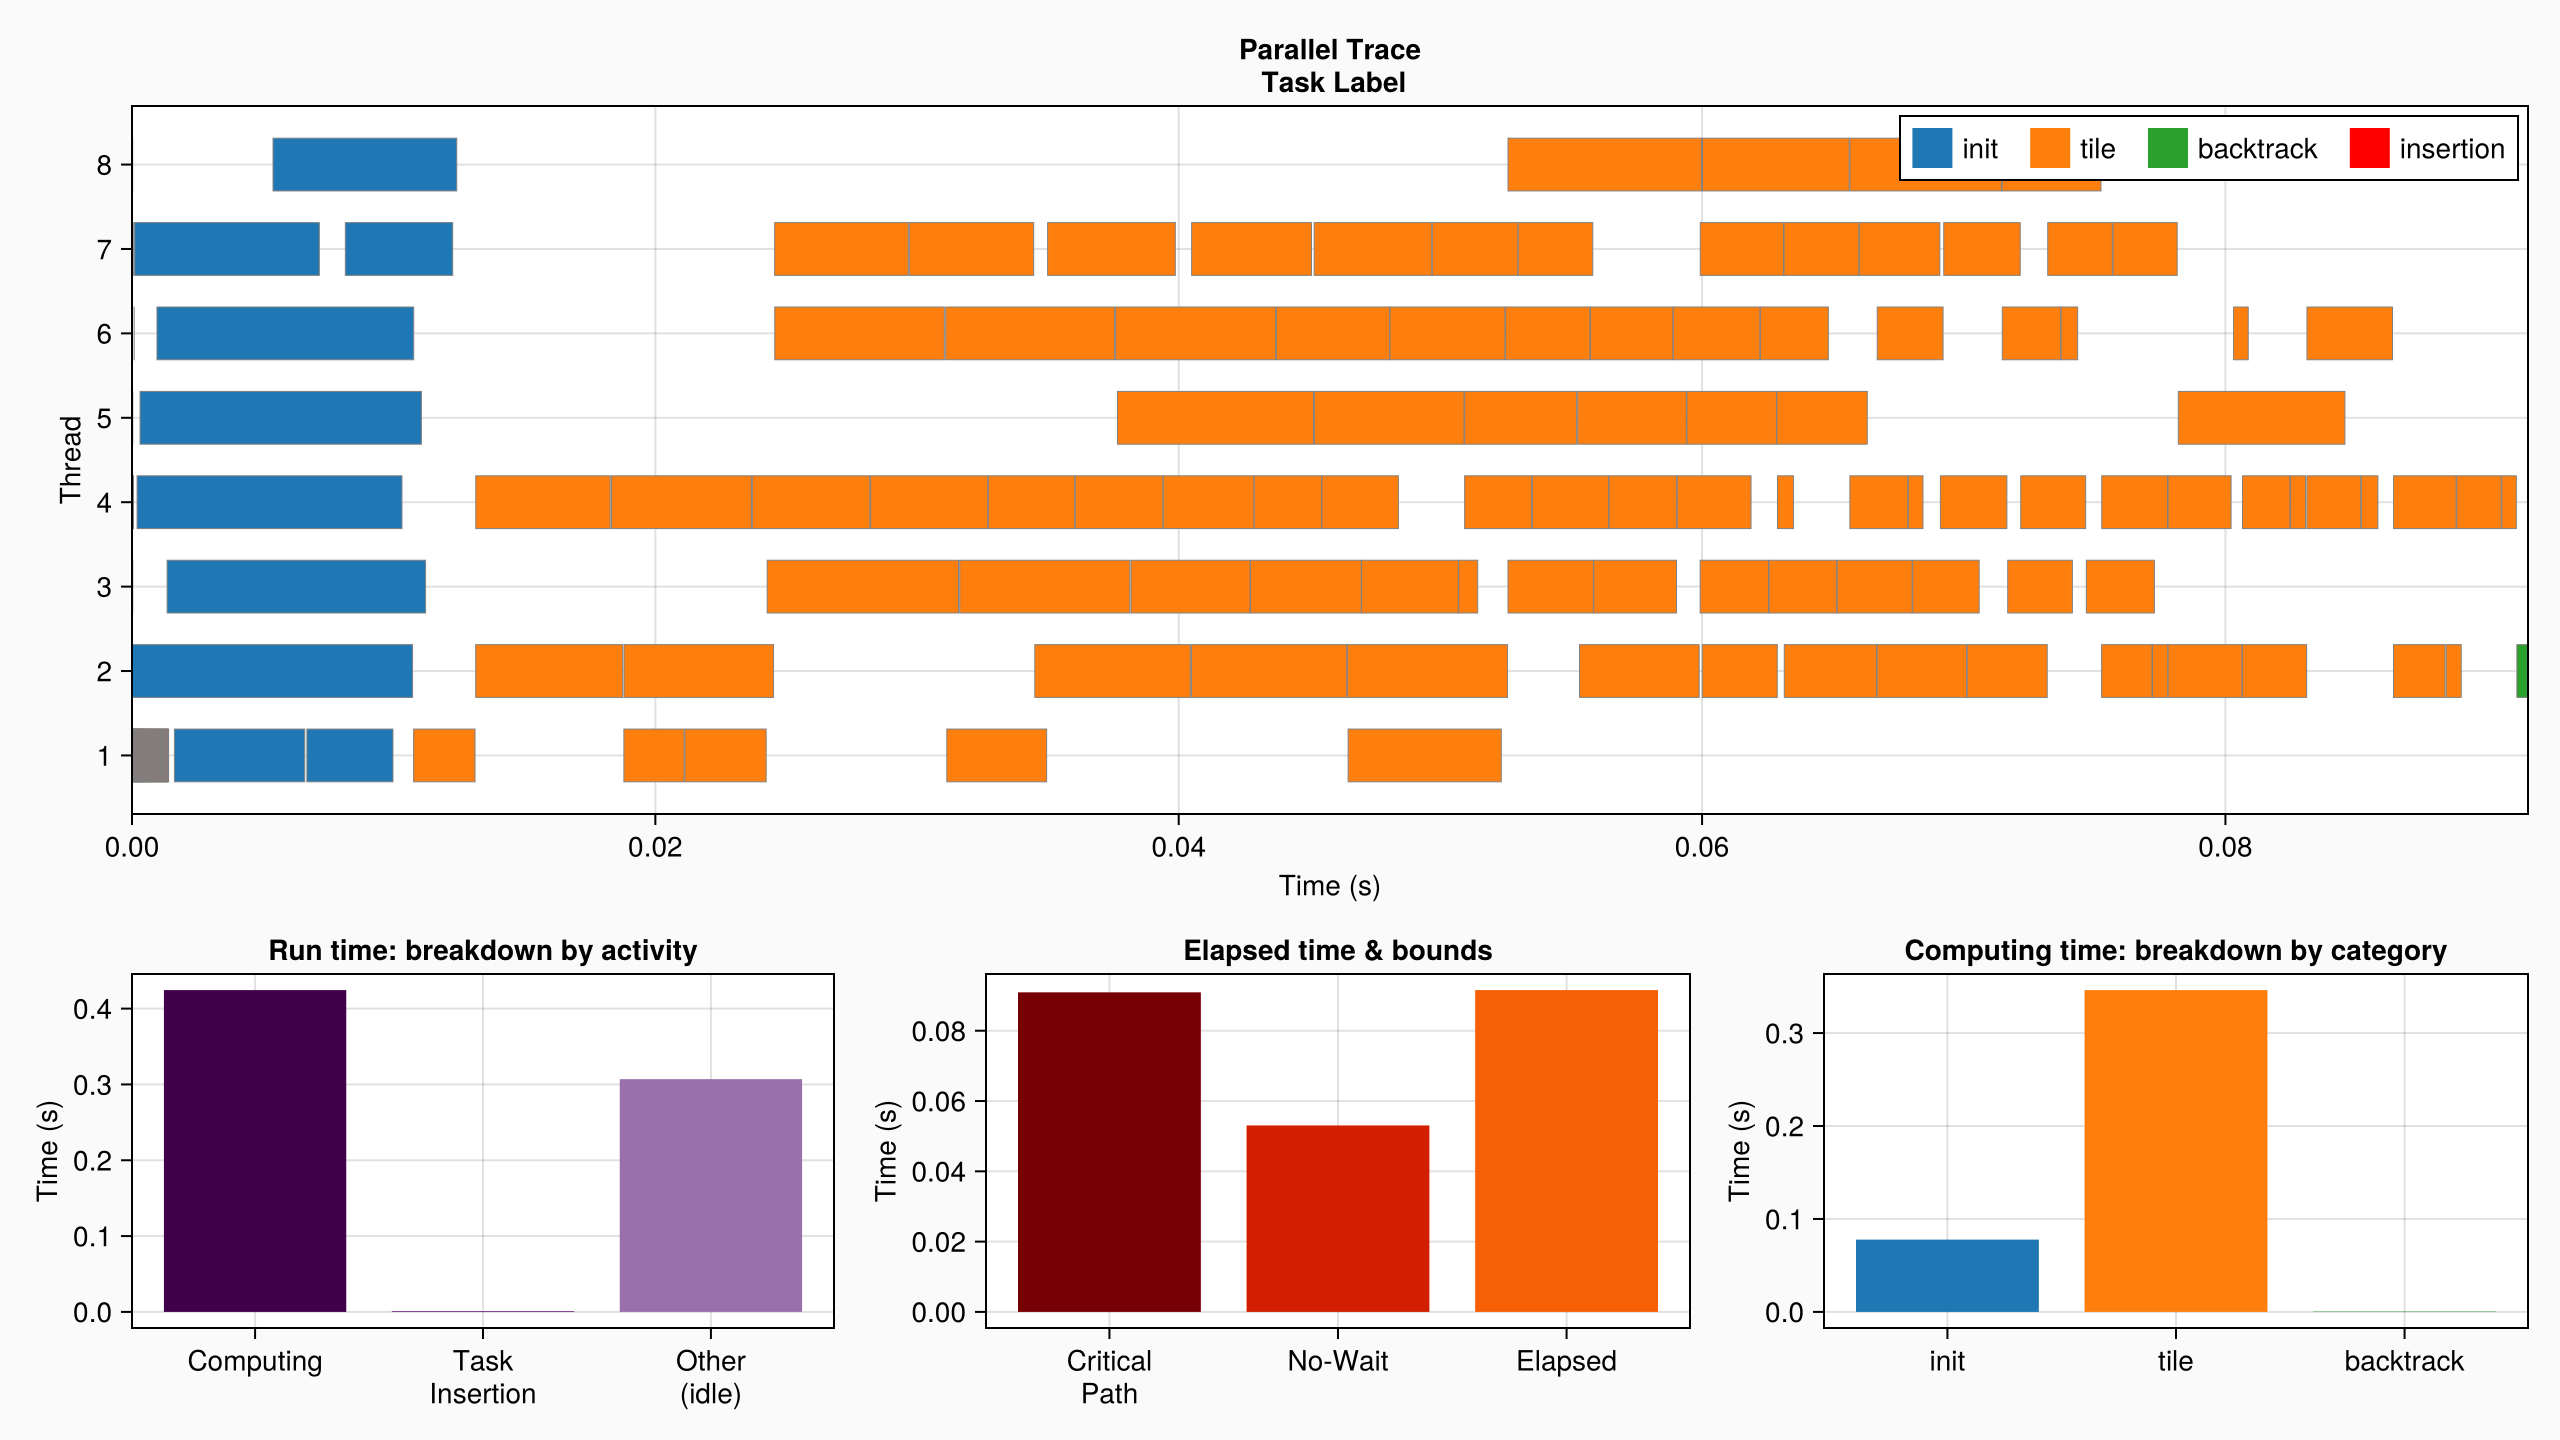

In [19]:
plot(log_info; categories = ["init", "tile", "backtrack"])

Here, we see for example that the run time is bounded by the length of the
critical path, which means that adding more threads would not help much. One way
to try and improve the performance is to expose more parallelism by dividing the
problem into smaller chunks. Give it a try and see what you get!

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*